# **Heart Disease Prediction** 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🧩 **STEP 1: Import All Required Libraries**

In [2]:
# 📦 Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.tabular.all import *
import warnings
warnings.filterwarnings("ignore")
import json

from sklearn.mixture import BayesianGaussianMixture
import joblib

# 🧼 **STEP 2: Load and Inspect the Dataset**

In [3]:
path = "/kaggle/input/playground-series-s6e2"

In [4]:
# Import the training data from a CSV file using the specified directory path
train_df = pd.read_csv(f"{path}/train.csv")
# Import the testing data from a CSV file for model evaluation
test_df = pd.read_csv(f"{path}/test.csv")
# Display the dimensions (rows, columns) of both dataframes to verify successful loading
print(train_df.shape)
print(test_df.shape)
# Provide a summary of the training data, including data types and non-null counts
print(train_df.info())
# Preview the first five rows of the training dataset to understand the structure
train_df.head()

(630000, 15)
(270000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 n

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


# 🎯**Step 3: Preprocessing**

### **✨a. Check for duplicates**

In [5]:
# Returns the total count of duplicate rows
duplicate_count = train_df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

# Remove duplicates and update the DataFrame
train_df = train_df.drop_duplicates().reset_index(drop=True)

Total duplicate rows: 0


### **✔ b. Check for Imbalance**

Heart Disease
Absence     347546
Presence    282454
Name: count, dtype: int64
Heart Disease
Absence     0.55166
Presence    0.44834
Name: proportion, dtype: float64


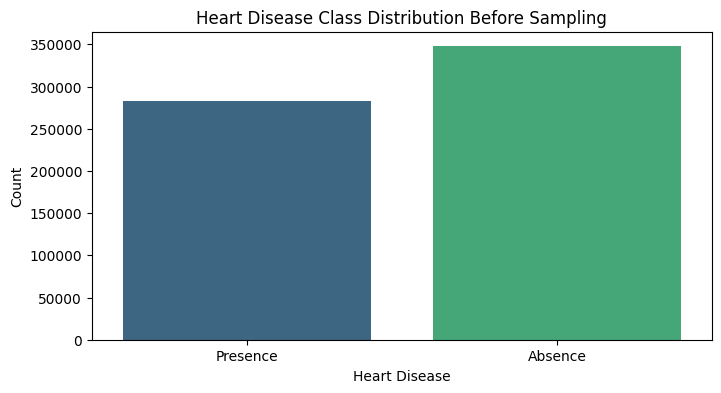

In [6]:
# Count the number of occurrences for each class in the target variable
print(train_df['Heart Disease'].value_counts())
# Calculate the percentage distribution to check for class imbalance
print(train_df['Heart Disease'].value_counts(normalize=True))
# Visualize the data distribution using a bar chart
plt.figure(figsize=(8,4))
sns.countplot(x=train_df['Heart Disease'], palette='viridis')
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.title("Heart Disease Class Distribution Before Sampling")
plt.show()

### 🧿 **c. Handles Correlation**

In [7]:
def remove_correlated_features(df, threshold=0.85):
    """
    Identifies and removes features that are highly correlated to reduce redundancy.
    """
    # Filter the dataframe to include only numeric columns for correlation calculation
    num_df = df.select_dtypes(include=['int64','float64'])

    # Compute the absolute correlation matrix (values range from 0 to 1)
    corr = num_df.corr().abs()

    # Create a mask to look only at the upper triangle of the matrix 
    # (prevents comparing a feature to itself or checking pairs twice)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )

    # Identify columns that have a correlation higher than the defined threshold
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    # Return the dataframe with correlated columns removed and the list of dropped names
    return df.drop(columns=to_drop), to_drop

# Apply the function to the training data and capture which columns were removed
train_df, removed_train_cols = remove_correlated_features(train_df)
# Drop the exact same columns from the test set to maintain consistency
test_df = test_df.drop(removed_train_cols, axis=1)
# Log the names of the dropped features for transparency
print("Dropped:", removed_train_cols)

Dropped: []


### ⚙️ **d. Split Features and Target**

In [8]:
# Separate features (X) and target (y) for model training
# We drop 'id' because it's a unique identifier and 'Heart Disease' because it's what we want to predict
X = train_df.drop(['id','Heart Disease'], axis=1)   # Independent variables
y = train_df['Heart Disease'] # Dependent variable

# Store the 'id' column from the test set separately to use later for the final submission file
test_ids = test_df['id']
# Remove 'id' from the test features to ensure it matches the structure of the training features
test_df = test_df.drop(['id'], axis=1)

### 🏹 **e. Feature Engineering**

In [9]:
# Define a function to treat low-cardinality numeric columns as categories
def convert_to_cat(df):
    """
    Iterates through all columns and converts those with 5 or fewer unique 
    values to string type (categorical). This prevents models from treating 
    ordinal/binary codes as continuous mathematical values.
    """
    for col in df.columns:
        # Check if the number of unique values in the column is 5 or less
        if df[col].nunique() <= 5:
            # Cast the column to string (object) type
            df[col] = df[col].astype(str)
    return df
# Apply the conversion to the training features
X = convert_to_cat(X)
# Apply the same logic to the test features to ensure data type consistency
test_df = convert_to_cat(test_df)

### 🧨 f. Identify categorical & numeric columns

In [10]:
# Identify and list all columns containing text or categorical data
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
# Identify and list all columns containing continuous numerical data
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

### 🎈**g. Mutual Information**

In [11]:
# Import Mutual Information for classification to measure dependency between variables
from sklearn.feature_selection import mutual_info_classif
# Import LabelEncoder to convert target labels into a numeric format
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder and transform the target variable 'y' into numeric integers
le = LabelEncoder()
mi_y = le.fit_transform(y) # Dependent variable

def make_mi_scores(X, y, numeric_cols):
    """
    Calculates Mutual Information scores to identify which features 
    have the most predictive power relative to the target.
    """
    # Calculate MI scores (higher values indicate stronger dependency)
    mi_scores = mutual_info_classif(X, y)
    # Organize scores into a Pandas Series for easier manipulation and indexing
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # Sort the scores in descending order (most important features at the top)
    mi_scores = mi_scores.sort_values(ascending=False)
    # Filter for features that provide a meaningful contribution (score > 0.005)
    mi_features = mi_scores[mi_scores > 0.005].index.tolist()
    return mi_scores, mi_features

# Execute the function to get the full score list and the filtered feature names
mi_scores, mi_features = make_mi_scores(X, mi_y, numeric_cols)
# Display the scores to evaluate feature importance at a glance
mi_scores 

Thallium                   0.233980
Chest pain type            0.189038
Sex                        0.132802
Max HR                     0.128839
Slope of ST                0.124765
Exercise angina            0.123747
Number of vessels fluro    0.120516
ST depression              0.107090
EKG results                0.077007
Age                        0.030481
Cholesterol                0.011611
BP                         0.011265
FBS over 120               0.001443
Name: MI Scores, dtype: float64

### **g. Bar plot to make comparisions easier**

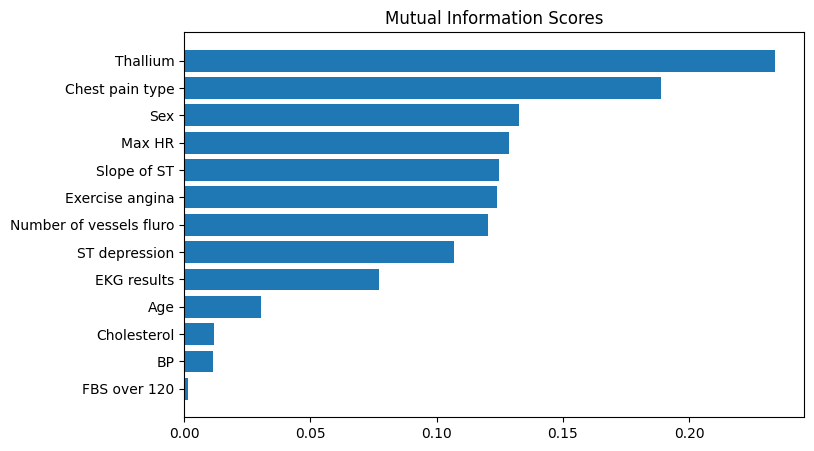

In [12]:
# Define a function to visualize the calculated Mutual Information (MI) scores
def plot_mi_scores(scores):
    # Sort scores in ascending order to place the most important features at the top of the horizontal bar chart
    scores = scores.sort_values(ascending=True)
    # Create an array for the vertical positions of the bars
    width = np.arange(len(scores))
    # Get the feature names from the index to use as labels
    ticks = list(scores.index)
    # Create a horizontal bar plot (barh) for better readability of feature names
    plt.barh(width, scores)
    # Map the feature names to the corresponding bar positions
    plt.yticks(width, ticks)
    # Set a clear title for the visualization
    plt.title("Mutual Information Scores")

# Initialize the figure with high resolution and specific dimensions for clarity
plt.figure(dpi=100, figsize=(8, 5))
# Call the function to generate the plot using your previously calculated scores
plot_mi_scores(mi_scores)

In [13]:

# Output the list of features that passed the Mutual Information threshold
print(mi_features)
# Filter the training features (X) to keep only the most predictive columns
X = X[mi_features]
# Apply the same filter to the test set to ensure consistency for predictions
test_df = test_df[mi_features]

# Export the list of selected features to a JSON file
# This is crucial for production/deployment to ensure the model receives the correct inputs later
with open('/kaggle/working/selected_features.json', 'w') as f:
    json.dump(mi_features, f)

['Thallium', 'Chest pain type', 'Sex', 'Max HR', 'Slope of ST', 'Exercise angina', 'Number of vessels fluro', 'ST depression', 'EKG results', 'Age', 'Cholesterol', 'BP']


### 🚀 **H. Cluster**

In [14]:
# 1. FIT THE MODEL (Using Bayesian Gaussian Mixture for soft-clustering)
# n_components=10 sets the maximum clusters; the model will prune unused ones
bgm = BayesianGaussianMixture(
                            n_components=10, 
                            weight_concentration_prior=0.01, 
                            random_state=42
                            )
bgm.fit(X) 

# 2. CAPTURE ALL PREDICTIONS FIRST
# Generate both soft (probabilities) and hard (cluster labels) assignments for both sets
# This ensures we have the data ready before modifying the dataframes themselves
bgm_probs_train = bgm.predict_proba(X)
bgm_labels_train = bgm.predict(X)

bgm_probs_test = bgm.predict_proba(test_df)
bgm_labels_test = bgm.predict(test_df)

# 3. NOW ADD CLUSTERING FEATURES TO TRAINING SET
# Identify how many clusters the model actually used (where weight is significant)
n_active = (bgm.weights_ > 0.01).sum()
# Add a column for each active cluster's probability as a new feature
for i in range(n_active):
    X[f'bgm_prob_{i}'] = bgm_probs_train[:, i]

# Add the hard cluster assignment as a categorical feature
X['bgm_cluster'] = bgm_labels_train

# 4. NOW ADD THE SAME COLUMNS TO TEST SET
# It is critical to use the same logic for the test set to avoid shape mismatch during inference
for i in range(n_active):
    test_df[f'bgm_prob_{i}'] = bgm_probs_test[:, i]
test_df['bgm_cluster'] = bgm_labels_test

# Final logging to verify the process and check cluster significance
print("Success! Features added without dimension mismatch.")
print(f"Weights: {bgm.weights_}")
print(f"Active clusters: {n_active}")
print(f"X features kept: {X.shape[1]}")



# Save the trained Bayesian Gaussian Mixture model to a file
# This allows you to reload the exact clustering logic later without retraining, 
# which is essential for consistent predictions on new data.
joblib.dump(bgm, '/kaggle/working/bgm_clustering_model.joblib')

Success! Features added without dimension mismatch.
Weights: [0.04654099 0.00719094 0.16764595 0.05678266 0.00313174 0.00212707
 0.12468361 0.00412327 0.57090292 0.01687083]
Active clusters: 6
X features kept: 19


['/kaggle/working/bgm_clustering_model.joblib']

In [15]:
# Refresh the lists of categorical and numerical columns to include the newly engineered BGM features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
# Recombine the feature set (X) and target variable (y) into a single DataFrame for final processing or visualization
df = pd.concat([X, y], axis=1)
# Verify the final dimensions of the updated dataset
df.shape

(630000, 20)

# ✨ **Step 4: Training with XGBoost Classification using Bayesearchcv**

In [16]:
# Import XGBoost for gradient boosting and Scikit-Optimize for Bayesian tuning
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score


# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, mi_y, test_size=0.2, random_state=42)

# Apply One-Hot Encoding to convert categorical text labels into binary columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols)

# Align the feature columns across all sets to ensure they have the exact same structure
# This handles cases where a category might exist in training but not in testing
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='left', axis=1, fill_value=0
)

# Align the new test_df to Train
_, test_df_encoded = X_train_encoded.align(
    test_df_encoded, join='left', axis=1, fill_value=0
)

# Initialize the XGBoost classifier with GPU acceleration and early stopping
xgb_clf = xgb.XGBClassifier(
    eval_metric='auc',
    n_jobs=1,
    device='cuda', # Utilizes GPU for faster training
    early_stopping_rounds=10,
    verbosity=0,
)

# Define the range of values to test for hyperparameter optimization
search_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'n_estimators': Integer(100, 1000),
    'subsample': Real(0.5, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'gamma': Real(1e-9, 0.5, prior='log-uniform')
}

# Set up Bayesian Search to find the best parameters via cross-validation
opt = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=search_space,
    n_iter=20,      # Number of parameter settings sampled
    cv=3,           # Cross-validation folds
    n_jobs=-1,      # Use all available cores
    random_state=42,
    scoring='roc_auc', 
    verbose=1
)

# Execute the hyperparameter search using the validation set for early stopping
opt.fit(X_train_encoded, y_train, eval_set=[(X_test_encoded, y_test)], verbose=False)


# Display the performance and parameters of the top-performing model
print(f"Best Score: {opt.best_score_}")
print(f"Best Params: {opt.best_params_}")

# Extract the optimized model for evaluation
best_XG_model = opt.best_estimator_

# Generate predictions on the unseen test data
y_pred = best_XG_model.predict(X_test_encoded)

# Detailed performance evaluation using Precision, Recall, and F1-Score
print("---" * 30 )
print("Test Classification Report:")
print(classification_report(y_test, y_pred))
# Print Confusion Matrix to see True Positives/False Negatives
print("Confusion Matrix: ")
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Print overall accuracy
acc = round(accuracy_score(y_test, y_pred),3)
print("Accuracy: ", acc)

# Get probabilities for the positive class (column 1)
y_xgb_probs = best_XG_model.predict_proba(X_test_encoded)[:, 1]

#Calculate the score
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_xgb_probs)}")

# Save the trained model and metadata for future deployment
joblib.dump(best_XG_model, '/kaggle/working/best_xgboost_model.pkl')
# Save the list of names
joblib.dump(categorical_cols, '/kaggle/working/categorical_cols.pkl')
# Save the column names (schema) so the model receives features in the correct order later
model_columns = list(X_train_encoded.columns)
joblib.dump(model_columns, '/kaggle/working/model_columns.pkl')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

['/kaggle/working/model_columns.pkl']

# ✂️ **STEP 5: Traing with FastAI**

In [17]:
#Split Dataset into 80/20 Train and Validation Sets with a fixed seed for reproducibility
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
# Initialize the fastai TabularPandas object to handle high-level preprocessing
# procs: Automatically handles category encoding, missing value imputation, and feature scaling
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = categorical_cols,
                   cont_names = numeric_cols,
                   y_names='Heart Disease',
                   splits=splits,
                    y_block=CategoryBlock() # Treats the target as a classification category
                  )
# Preview the first two rows of the processed features (xs) to verify transformations
to.xs.iloc[:2]
# Convert the tabular object into DataLoaders with a batch size of 64 for deep learning training
dls = to.dataloaders(bs=64)

In [18]:
dls.show_batch()

,Thallium,Chest pain type,Sex,Slope of ST,Exercise angina,Number of vessels fluro,EKG results,Max HR,ST depression,Age,Cholesterol,BP,bgm_prob_0,bgm_prob_1,bgm_prob_2,bgm_prob_3,bgm_prob_4,bgm_prob_5,bgm_cluster,Heart Disease
0,3,4,1,1,0,1,0,138.000000,2.747608e-08,54.0,250.000000,130.0,6.458404e-10,-1.385842e-11,7.075965e-04,-6.288513e-10,-6.144087e-13,-3.288780e-11,6.0,Absence
1,7,4,1,1,1,0,2,108.999998,8.000000e-01,54.0,233.000000,125.0,6.458404e-10,-1.385842e-11,1.712462e-03,-6.288513e-10,-6.144087e-13,-3.288780e-11,6.0,Presence
2,7,4,1,2,0,0,0,156.000000,1.400000e+00,51.0,274.000000,130.0,6.458404e-10,-1.385842e-11,5.541027e-06,-6.288513e-10,-6.144087e-13,-3.288780e-11,8.0,Presence
3,3,4,1,2,1,0,0,132.000000,2.747608e-08,62.0,283.000001,140.0,6.458404e-10,-1.385842e-11,1.371546e-05,9.999862e-01,-6.144087e-13,-3.288780e-11,3.0,Absence
4,3,4,0,1,0,0,0,171.000000,2.747608e-08,54.0,199.000001,120.0,6.458404e-10,-1.385842e-11,2.434788e-09,-6.288513e-10,-6.144087e-13,-3.288780e-11,8.0,Absence
5,7,3,1,1,0,0,0,141.999999,2.747608e-08,69.0,271.000001,140.0,6.458404e-10,-1.385842e-11,3.138416e-07,-6.288513e-10,-6.144087e-13,-3.288780e-11,8.0,Absence
6,3,3,0,1,1,0,0,159.000000,2.747608e-08,64.0,243.000000,125.0,6.458404e-10,-1.385842e-11,2.434788e-09,1.000000e+00,-6.144087e-13,-3.288780e-11,3.0,Absence
7,3,1,0,1,0,0,2,170.000000,2.747608e-08,57.0,269.999999,140.0,6.458404e-10,-1.385842e-11,2.434788e-09,-6.288513e-10,-6.144087e-13,-3.288780e-11,8.0,Absence
8,7,4,1,1,1,3,2,144.000000,2.000000e+00,57.0,308.000000,130.0,6.458404e-10,-1.385842e-11,1.000000e+00,-6.288513e-10,-6.144087e-13,-3.288780e-11,2.0,Presence
9,3,4,0,2,1,0,2,162.000000,1.600000e+00,57.0,211.000000,130.0,6.458404e-10,-1.385842e-11,2.434788e-09,9.999211e-01,-6.144087e-13,-3.288780e-11,3.0,Presence


In [19]:
# Import the binary version of ROC-AUC specifically designed for two-class classification
from fastai.metrics import RocAucBinary

# Initialize a tabular deep learning model (Neural Network)
# metrics: Tracks both Accuracy and ROC-AUC during training to monitor performance
learn = tabular_learner(dls, metrics=[accuracy, RocAucBinary()])

### **Find the best learning rate**

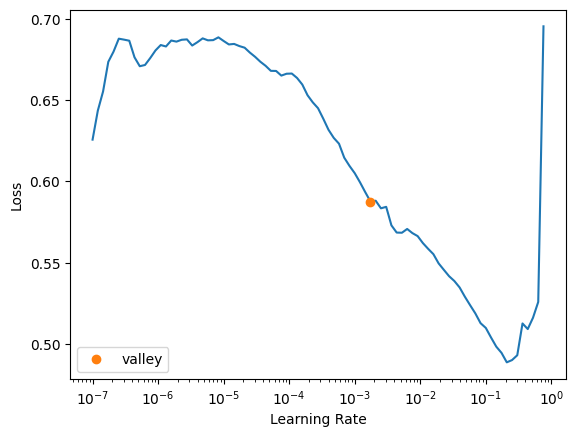

In [20]:
#Run the learning rate finder
suggested_lrs = learn.lr_find()

In [21]:
optimal_lr = suggested_lrs.valley # or suggested_lrs.steep

print(f"Suggested learning rate: {optimal_lr}")

Suggested learning rate: 0.001737800776027143


In [22]:
# Define training callbacks to manage model optimization and performance
# EarlyStopping: Halts training if ROC-AUC doesn't improve for 3 consecutive epochs
# SaveModel: Automatically exports the best version of the model to the specified file path
callbacks = [EarlyStoppingCallback(monitor='roc_auc_score', patience=3),
             SaveModelCallback(monitor='roc_auc_score', fname='/kaggle/working/best_fastai_model')]

# Set the learning rate discovered during your LR find process
optimal_lr =  0.00363078061491251
# Train the Neural Network using the 1-Cycle Policy for better convergence and speed
# Training for up to 20 epochs with the specified callbacks and learning rate
learn.fit_one_cycle(20, optimal_lr, cbs =  callbacks)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.289173,0.283104,0.882905,0.950233,01:14
1,0.286596,0.278079,0.885119,0.952263,01:14
2,0.269908,0.278394,0.885563,0.952290,01:14
3,0.278233,0.278267,0.885524,0.952709,01:15
4,0.277433,0.280481,0.884905,0.952758,01:17
5,0.268394,0.279118,0.885484,0.952087,01:15
6,0.287283,0.277011,0.885865,0.952565,01:14
7,0.285215,0.277591,0.885397,0.952418,01:15


Better model found at epoch 0 with roc_auc_score value: 0.9502332633924311.
Better model found at epoch 1 with roc_auc_score value: 0.95226304528957.
Better model found at epoch 2 with roc_auc_score value: 0.9522896140974506.
Better model found at epoch 3 with roc_auc_score value: 0.9527092913085503.
Better model found at epoch 4 with roc_auc_score value: 0.9527578177036957.
No improvement since epoch 4: early stopping


### **Show Result**

In [23]:
learn.show_results()

,Thallium,Chest pain type,Sex,Slope of ST,Exercise angina,Number of vessels fluro,EKG results,Max HR,ST depression,Age,Cholesterol,BP,bgm_prob_0,bgm_prob_1,bgm_prob_2,bgm_prob_3,bgm_prob_4,bgm_prob_5,bgm_cluster,Heart Disease,Heart Disease_pred
0,1.0,4.0,2.0,2.0,1.0,1.0,1.0,0.949974,0.510545,-1.227288,1.275537,1.970547,-0.22087,-0.085081,-0.449801,-0.244485,-0.056093,-0.046409,0.718325,1.0,0.0
1,3.0,4.0,2.0,1.0,1.0,1.0,1.0,-0.356989,0.088485,0.589494,1.572429,-0.166084,-0.22087,-0.085081,-0.449793,-0.244485,-0.056093,-0.046409,0.718325,1.0,1.0
2,3.0,4.0,2.0,1.0,1.0,1.0,3.0,0.218074,-0.755637,0.589494,1.720874,0.501613,-0.22087,-0.085081,-0.449790,-0.244485,-0.056093,-0.046409,0.718325,0.0,1.0
3,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.368202,-0.755637,-0.500575,-0.357365,0.301304,-0.22087,-0.085081,-0.449802,-0.244485,-0.056093,-0.046409,0.718325,0.0,0.0
4,1.0,4.0,2.0,2.0,1.0,2.0,1.0,-0.304711,1.249151,1.195089,-0.980837,-0.032544,-0.22087,-0.085081,-0.446365,-0.244485,-0.056093,-0.046409,-0.012289,1.0,1.0
5,1.0,4.0,2.0,2.0,1.0,2.0,1.0,0.270353,-0.122546,-0.985051,2.077144,0.635153,-0.22087,-0.085081,-0.447852,-0.244485,-0.056093,-0.046409,-0.012289,0.0,0.0
6,1.0,3.0,2.0,2.0,2.0,1.0,3.0,-0.566104,-0.755637,-0.137219,-0.060474,1.302850,-0.22087,-0.085081,-0.449800,4.073652,-0.056093,-0.046409,-1.108209,1.0,0.0
7,1.0,4.0,2.0,2.0,1.0,3.0,1.0,0.165796,1.354667,1.437326,-1.990268,-1.367939,-0.22087,-0.085081,2.229860,-0.244485,-0.056093,-0.046409,-1.473516,1.0,1.0
8,3.0,4.0,2.0,2.0,2.0,2.0,3.0,-0.461547,0.510545,0.468375,0.830200,-0.032544,-0.22087,-0.085081,2.229860,-0.244485,-0.056093,-0.046409,-1.473516,1.0,1.0


### **Check the FastAI Metrics**

In [ ]:
# Run the validation dataset through the model to retrieve performance metrics
# Unpacks the total loss, accuracy, and ROC-AUC for evaluation
val_loss, acc, auc = learn.validate()

# Log the final results, rounded for readability and precision
print(f"Validation Loss: {round(val_loss, 3)}")
print(f"Validation Accuracy: {round(acc, 3)}")
print(f"Your Best ROC-AUC Score: {auc:.4f}")

### **Save the Model**

In [ ]:
# Export Complete Model
learn.export('/kaggle/working/my_complete_model.pkl')

# **Check Model on Validation Set**

In [ ]:
# from fastai.metrics import RocAucBinary

# # Add it to your metrics list
# learn = tabular_learner(dls, metrics=[accuracy, RocAucBinary()])

# learn.load('/kaggle/input/models/dijeh08/fast-ai/pytorch/default/1/best_fastai_model')

In [ ]:
# Create a Fastai DataLoader for the test features to match the training pipeline
dl_Xtest = learn.dls.test_dl(X_test)
# Generate predictions and probabilities for the test set using the Neural Network
ft_probs_Xtest, target_Xtest = learn.get_preds(dl=dl_Xtest)
# Extract only the probabilities for the positive class (column 1) as a NumPy array
ft_probs_Xtest = ft_probs_Xtest[:, 1].numpy()

# Initialize variables to track the highest performance during weight optimization
best_auc = 0
best_w = 0

print("Weight (XGB / Fastai) | ROC-AUC")
print("-" * 35)

# Iterate through different blending ratios (0% to 100%) to find the "sweet spot"
# np.linspace(0, 1, 11) tests weights like 0.0, 0.1, 0.2... 1.0
for w_xgb in np.linspace(0, 1, 11):
    w_fastai = 1 - w_xgb
    
    # Calculate the weighted average of probabilities from both models
    ensemble_probs = (w_xgb * y_xgb_probs) + (w_fastai * ft_probs_Xtest)
    # Evaluate the combined performance using ROC-AUC
    current_auc = roc_auc_score(y_test, ensemble_probs)
    print(f"{w_xgb:.1f} / {w_fastai:.1f}         | {current_auc:.5f}")
    # Update the best score and weight if the current blend outperforms previous ones
    if current_auc > best_auc:
        best_auc = current_auc
        best_w = w_xgb

print("-" * 35)
print(f"Best Weight for XGBoost: {best_w:.1f}")
print(f"Best Ensemble ROC-AUC: {best_auc:.5f}")

# 🔑**Step 6: Test set Prediction**

In [28]:
# Create a Fastai DataLoader for the unseen competition test data
# This ensures the test features undergo the exact same preprocessing (Scaling/Categorify) as the training set
dl_test = learn.dls.test_dl(test_df)
# Generate final predictions (probabilities) and target placeholders using the Neural Network
# get_preds handles the inference pass across all batches in the test DataLoader
ft_probs, target = learn.get_preds(dl=dl_test)
# Display the raw probability tensors (typically contains columns for both Class 0 and Class 1)
print(ft_probs)
# Verify the dimensions of the output to ensure it matches the number of rows in your test set
print("Probabilities Shape:", ft_probs.shape)

tensor([[0.0939, 0.9061],
        [0.9985, 0.0015],
        [0.0125, 0.9875],
        ...,
        [0.9492, 0.0508],
        [0.7467, 0.2533],
        [0.9709, 0.0291]])
Probabilities Shape: torch.Size([270000, 2])


In [29]:
# Display the unique class labels as defined by the Fastai DataLoaders
print(learn.dls.vocab)

['Absence', 'Presence']


# 🎻**Voting Ensembled**

In [30]:
# --- 1. Get Fastai Probabilities ---
ft_probs = ft_probs.numpy() # Convert to NumPy

# --- 2. Get XGBoost Probabilities ---
xgb_probs = best_XG_model.predict_proba(test_df_encoded)


# 2. Apply your chosen weights (e.g., 60% XGB / 40% Fastai)
ensembled_probs = ((0 * ft_probs) + (1 *xgb_probs)) / 2

# Get the final class (0 or 1) based on the highest average probability
final_preds = np.argmax(ensembled_probs, axis=1)

# Get the probability for the positive class (column 1) for your CSV
final_pos_probs = ensembled_probs[:, 1]
print(final_pos_probs)

[0.47060475 0.0043387  0.49372658 ... 0.02258719 0.0973405  0.0162455 ]


In [31]:
# 2. Extract the column for the "Positive" class (usually index 1)
# and convert to a numpy array
test_df['Heart Disease'] = final_pos_probs

# 3. (Optional) Add the Hard Label (0 or 1) as well
test_df['Heart Disease Class'] = torch.from_numpy(final_preds) # ft_probs.argmax(dim=1).numpy() # or 


# 💾 **Step 7: Save Submission**

In [32]:
submission = pd.DataFrame({
            "id": test_ids,
            "Heart Disease": final_pos_probs #ft_probs[:, 1].numpy()
        })
#submission = submission.astype('object')
submission.to_csv("/kaggle/working/submission.csv", index=False)
print("✅ Heart Disease prediction CSV generated!")

✅ Heart Disease prediction CSV generated!


# **Step 8: Test on new dataset**

In [33]:
# Creating data as a dictionary
data = {
    "Age": [58],
    "Sex": [0],
    "Chest pain type": [1],
    "BP": [152],
    "Cholesterol": [239],
    "FBS over 120": [0],
    "EKG results": [0],
    "Max HR":[158],
    "Exercise angina": [1],
    "ST depression": [3.6],
    "Slope of ST":[2],
    "Number of vessels fluro": [2],
    "Thallium": [7]
}

newDf = pd.DataFrame(data)
newDf.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,58,0,1,152,239,0,0,158,1,3.6,2,2,7


In [34]:
# newDf['Age>55'] = (newDf["Age"] > 55).astype(int)
with open('/kaggle/working/selected_features.json', 'r') as f:
    required_features = json.load(f)

newDF = newDf[required_features]
newDF.head()

,Thallium,Chest pain type,Sex,Max HR,Slope of ST,Exercise angina,Number of vessels fluro,ST depression,EKG results,Age,Cholesterol,BP
0,7,1,0,158,2,1,2,3.6,0,58,239,152


In [35]:
import joblib

n_active = 6
# Load the model back
bgm = joblib.load('bgm_clustering_model.joblib')

# NOW ADD COLUMNS TO TEST SET
bgm_probs_newDF = bgm.predict_proba(newDF)
bgm_labels_newDF = bgm.predict(newDF)

for i in range(n_active):
    newDF[f'bgm_prob_{i}'] = bgm_probs_newDF[:, i]
newDF['bgm_cluster'] = bgm_labels_newDF

In [36]:
# 1. Load everything
xgb_model = joblib.load('/kaggle/working/best_xgboost_model.pkl')
cat_cols = joblib.load('/kaggle/working/categorical_cols.pkl')
final_cols = joblib.load('/kaggle/working/model_columns.pkl')

# 2. Encode strings to dummies
new_data_encoded = pd.get_dummies(newDF, columns=cat_cols)

# 3. Force match the training schema (Adds missing columns as 0, drops extras)
new_data_encoded = new_data_encoded.reindex(columns=final_cols, fill_value=0)

# 4. Predict
preds = xgb_model.predict(new_data_encoded)
proba_xgb = xgb_model.predict_proba(new_data_encoded)[:, 1]


In [37]:
learn = load_learner('/kaggle/working/my_complete_model.pkl')

print("Success! Model and preprocessing rules loaded.")


# Create a test dataloader from your new data (e.g., a DataFrame or list of files)
newDF_dl = learn.dls.test_dl(newDF)
# Get predictions for the entire batch
# get_preds returns (probabilities, targets/labels)
fast_probs, _ = learn.get_preds(dl=newDF_dl)

fast_probs = fast_probs.numpy()
# Average the probabilities from both models
# Resulting shape: [num_rows, 2]
final_probs_ = ((0.1*fast_probs) + (0.9*proba_xgb)) / 2

# Get the final class (0 or 1) based on the highest average probability
final_preds_ = np.argmax(final_probs_, axis=1)

# Get the probability for the positive class (column 1) for your CSV
final_pos_probs_ = final_probs_[:, 1]


# 2. Map indices to "Yes" or "No"
# Typically: 0 = "No", 1 = "Yes" (depends on how you trained your model)
labels = learn.dls.vocab
final_newDF_prediction = [labels[idx] for idx in final_preds_]
print(final_newDF_prediction[0])

Success! Model and preprocessing rules loaded.


Presence
